# 2B - Representational Similarity with Story Reading fMRI data
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/annabavaresco/ancm2024/blob/main/docs/week_2/2B_RSA_with_fMRI_Data.ipynb)
[![View filled in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annabavaresco/ancm2024/blob/main/docs/week_2/2B_RSA_with_fMRI_Data.ipynb)

_by Marianne de Heer Kloots, September 2022_

---

In the first part of this week's tutorial we saw how the structure of the embeddings space changes over model layers: the embeddings become more contextualized in deeper layers.

Recent work comparing language model activations to human brain measurements suggests that these deeper and more contextualized layers align better with the brain than the earlier layers (for example [Caucheteux & King, 2022](https://doi.org/10.1038/s42003-022-03036-1); [Schrimpf et al., 2021](https://doi.org/10.1073/pnas.2105646118)). These studies use trained regression models to map from model activations to brain signals, but we can also use RSA to analyze the same phenomenon. Just as we computed the correlation of RDMs from different model layers before, we can now compute the correlation between model and brain RDMs. So is it true that embeddings from later model layers form more brain-like representational spaces, compared to earlier model layers?

To answer this question, we'll use fMRI scans recorded from one subject in an experiment where subjects read a chapter from the first Harry Potter book ([Wehbe et al., 2014](https://doi.org/10.1371/journal.pone.0123148)). Participants in the experiment were presented with the chapter text through Rapid Serial Visual Presentation (RSVP), meaning that the words of the chapter appeared one by one on a screen, for 500 ms each. The brain scan TR (repetition time) was 2 seconds, meaning that every 2 seconds a 3d brain volume was recorded. This means that (almost\*) every scan records the activity of reading 4 words. We'll therefore also average the embeddings over 4 words on the model side, in order to create so-called 'TR embeddings' that give us the same temporal resolution as we have from the participant. In addition, to account for the haemodynamic response delay\**, we take the brain scan recorded 4 seconds (2 TRs) after each text presentation as the response to that text. Finally, we restrict ourselves to voxels recorded in the left anterior temporal lobe (LATL), which is generally known to be an important area for semantics and language processing (see e.g. [Bonner & Price, 2013](https://doi.org/10.1523/JNEUROSCI.0041-13.2013), [Bemis & Pylkkänen, 2013](https://doi.org/10.1093/cercor/bhs170)).

_____
\* In practice, the experiment was divided into 4 blocks, and the last scan in each block contains reading activity for only 3 words. In the code below, we provide you with all 1295 TR texts (one on each line in the `tr_texts.txt` file) and the corresponding 1295 brain responses, so the inputs and recorded activations are aligned correctly.

\** The signal recorded in fMRI studies is the so-called Blood Oxygen Level Dependent (BOLD) response, which takes about [4-6 seconds](https://www.nature.com/scitable/blog/brain-metrics/what_does_fmri_measure/) after stimulus presentation to reach its peak. We choose 4 seconds here based on earlier work where we found this to work best for this dataset ([Abnar et al., 2019](https://aclanthology.org/W19-4820/); figure 6).

In [ ]:
%%capture
!pip -q install pathlib wget transformers nilearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 23.9 MB/s eta 0:00:00


For this part of the tutorial, we import some helper functions from Marianne's research code for dealing with the fMRI data. If you're curious to know what is going on under the hood, you can look up any specific function in the [fmri_data_loading.py](https://github.com/clclab/ANCM/blob/main/lab2/fmri_data_loading.py) file, or run a code cell with a function name followed by `?`. Although some of these functions have different names than the ones we used before, it should be clear that we will be following the same steps overall: computing distance matrices for different layers of our model (and now also for the brain), and then calculate the correlation between them for RSA.

In [ ]:
import wget
import os

if not os.path.exists('fmri_data_loading.py'):
  wget.download('https://raw.githubusercontent.com/clclab/ANCM/main/lab2/fmri_data_loading.py')
tr_texts_file = 'tr_texts.txt'
if not os.path.exists(tr_texts_file):
  wget.download('https://raw.githubusercontent.com/clclab/ANCM/main/lab2/tr_texts.txt')

In [ ]:
from transformers import AutoModel, AutoTokenizer
import nilearn.signal
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from fmri_data_loading import *

In [ ]:
# load the model and tokenizer
model_name = 'bert-base-uncased'

model = AutoModel.from_pretrained(model_name,
            output_hidden_states=True,
            output_attentions=True)

# if you want to try a gpt-like model later,
# we'll need these tokenizer settings
if 'gpt' in model_name:
  tokenizer = AutoTokenizer.from_pretrained(model_name,
                                            add_prefix_space=True)
  tokenizer.pad_token = tokenizer.eos_token
# but this will work for bert
else:
  tokenizer = AutoTokenizer.from_pretrained(model_name)

torch.set_grad_enabled(False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Below we download the data from subject 8 in the Wehbe et al. (2014) experiment. You can find more information on this dataset, as well as the data from other subjects, [here](http://www.cs.cmu.edu/~fmri/plosone/). In particular, a description of all the information available per subject is available [here](http://www.cs.cmu.edu/~fmri/plosone/files/description.txt) (the original data is stored in .mat files, which we convert to python dictionaries below, but they contain the same information; you can run the `load_subj_dict?` cell below to see more information about the structure of the dictionaries).

In [ ]:
load_subj_dict?

In [ ]:
# download data for subject 8
subj_raw_file = 'subject_8.mat'
if not os.path.exists(subj_raw_file):
    url = 'http://www.cs.cmu.edu/~fmri/plosone/files/subject_8.mat'
    wget.download(url)

# load into python dictionary
subj_dict = load_subj_dict(subj_raw_file)

# preprocess fMRI signals
subj_cleaned_file = 'subject_8_clean.npy'
if not os.path.exists(subj_cleaned_file):
    # preprocessing parameters
    cleaning_params = {
        't_r': 2,                 # TR length in seconds
        'low_pass': None,         # low-pass filter frequency cutoff (Hz)
        'high_pass': 0.005,       # high-pass filter frequency cutoff (Hz)
        'standardize': 'zscore',  # standardization method
        'detrend': True,          # whether to apply detrending
    }

    cleaned_subj_dict = copy.copy(subj_dict)
    cleaned_subj_dict['data'] = nilearn.signal.clean(subj_dict['data'],
                                    runs=subj_dict['time'][:,1],
                                    **cleaning_params)
    np.save(subj_cleaned_file, cleaned_subj_dict)
subj_dict = np.load(subj_cleaned_file, allow_pickle=True).item()

Below we select the regions of interest (ROIs) in the left anterior temporal lobe (LATL) from which we will retrieve the brain responses and construct the brain-side RDMs. You can later define another selection of ROIs yourself, if you like (run `subj_dict['meta']['ROInumToName']` to see a list of all available ROIs in this dataset, they are based on the [AAL Single-Subject atlas](https://www.pmod.com/files/download/v36/doc/pneuro/6750.htm)).

In [ ]:
# subregions of left-anterior temporal lobe
LATL_ROI = ['Temporal_Sup_L', 'Temporal_Pole_Sup_L',
            'Temporal_Mid_L', 'Temporal_Pole_Mid_L', 'Temporal_Inf_L',
            'Fusiform_L', 'ParaHippocampal_L']

We now have the brain response scans for each of the 1295 text TRs; there are 4210 voxels in our LATL ROI selection.

In [ ]:
brain_responses = get_text_response_scans(subj_dict,
                                          delay=2,
                                          ROI=LATL_ROI) # delay in TRs (1 TR = 2 sec)
brain_responses['voxel_signals'].shape

(1295, 4210)

Below we load `tr_texts` (a list of texts, one for every TR containing the text presented during that TR), and we calculate the number of words presented during each TR (a list of mostly 4s and some 3s). We then split the text into sentences which we will present to our model to extract the embeddings. Note that for BERT, this means that the model will for some TRs have access to the words at the end of the sentence, which the experiment participant hadn't seen at the time the brain scan was recorded. If you'd like, you can try out different ways of providing input text to the model, for example a fixed text window for each TR excluding words presented after that TR (a way to 'make BERT causal' as discussed in the lecture).

In [ ]:
tr_texts = open(tr_texts_file, 'r').read().splitlines()
words_per_tr = [len(tr.split(' ')) for tr in tr_texts]
hp_sentences = create_context_sentences(tr_texts)

We process all sentences of the Harry Potter chapter through BERT, and extract the embeddings for each word at every layer. There are 5176 words and 13 'layers' (input embeddings + 12 model layers), which each have a 768-dimensional activation vector for every word.

In [ ]:
%%time
# this will take a few minutes
layer_acts_bert = get_layer_activations(model,
                      tokenizer,
                      hp_sentences)
layer_acts_bert = np.concatenate(layer_acts_bert)
print(layer_acts_bert.shape)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


(5176, 13, 768)
CPU times: user 2min 52s, sys: 616 ms, total: 2min 53s
Wall time: 2min 55s


Then we average over the words in each TR to get the 'TR embeddings':

In [ ]:
tr_embeddings_bert = get_tr_embeddings(layer_acts_bert, words_per_tr)
print(tr_embeddings_bert.shape)

(1295, 13, 768)


Now we have activations vectors for each of the 1295 text TRs for each layer of the model. We also have brain responses to each of the 1295 text TRs, so we can create RDMs for both! (13 RDMs for each layer of the model, and 1 RDM for subject 8's brain responses)

In [ ]:
RDMs_bert = [vector_distance_matrix(tr_embeddings_bert[:,layer,:],
                                   metric="cosine")
             for layer in range(tr_embeddings_bert.shape[1])]

RDM_brain = vector_distance_matrix(brain_responses['voxel_signals'],
                                   metric="cosine")

print(RDMs_bert[0].shape) # one of the model RDMs
print(RDM_brain.shape) # the brain RDM

(1295, 1295)
(1295, 1295)


We can compute the RSA score (Pearson's correlation) between each of the model layers and the brain responses now.

In [ ]:
rsa_scores_bert = [compute_rsa_score(RDM_brain,
                                     RDMs_bert[layer],
                                     score="pearsonr")
                   for layer in range(len(RDMs_bert))]

As we see below, the correlation values themselves are quite low (they might get a bit higher if you provide the model with more context text). But we do observe the expected qualitative pattern: the higher layers with more contextualized embeddings score up to twice as high in representational similarity compared to lower layers.

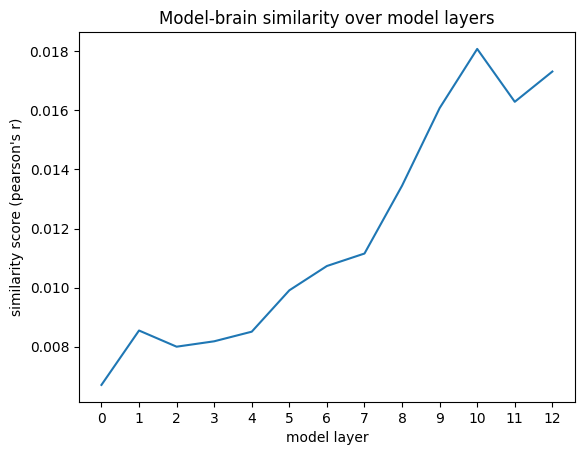

In [ ]:
plt.plot(rsa_scores_bert)
plt.xlabel('model layer')
plt.xticks(range(len(rsa_scores_bert)))
plt.ylabel('similarity score (pearson\'s r)')
plt.title('Model-brain similarity over model layers')
plt.show()

### **QUESTIONS**

At first sight, the result above seems to nicely confirm the idea that the more contextualized embeddings from middle-to-high model layers show better alignment with human brain responses. But what have we really learned about language processing?

To make sure that this result really captures something about the linguistic processes involved in story reading, we would ideally compare it to some 'control' or 'baseline' condition where we would _not_ expect the effect to occur. One option would be to compare results with a different brain region that we would not expect to be as much involved in language processing. Another option could be to shuffle the RDMs before computing the RSA scores, such that we compute the correlation between model and brain RDMs for unmatched TRs (you could do this several times to create a 'null distribution' of RSA scores). You might also want to see if the result can be reproduced at the group level (comparing RSA scores across individual subjects or computing a mean RDM for several subjects), compute some kind of 'noise ceiling' based on RDM-correlation across subjects ([Nili et al., 2014](https://doi.org/10.1371/journal.pcbi.1003553)), or compare to results using a different model architecture (like GPT-2).

Choose one of the options above, and compare the result obtained above to your 'baseline' / 'control' condition or analysis extension. Then write a concise report (less than one page) describing the approach you have used and answering the following questions:

- Do your new results still confirm the idea that contextualized embeddings from middle-to-high model layers show better alignment with language processing in the human brain?
- Why is your particular baseline / control / extension important to include in analyses comparing DNN activations and brain responses?
- What are some limitations of this particular baseline / control / extension for your analysis (i.e., alternative explanations that it does not rule out yet)?

Please also include in your report one (or more) plot(s) comparing the result obtained above to your 'baseline' / 'control' condition or analysis extension. The plot doesn't count towards the page limit.